In [1]:
import networkx as nx
import cirq
import recirq
import numpy as np

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
sns.set_style('ticks')
sns.set_palette('colorblind')

plt.rc('axes', labelsize=16, titlesize=16)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14, title_fontsize=16)

QBLUE = '#1967d2'
QRED = '#ea4335ff'
QGOLD = '#fbbc05ff'
QGREEN = '#34a853ff'
QGOLD2 = '#ffca28'
QBLUE2 = '#1e88e5'

In [3]:
n_qubits = 8
# rs = np.random.RandomState(52)
# graph = nx.random_regular_graph(3, n_qubits, seed=rs)
# nx.set_edge_attributes(graph, values=1, name='weight')

from recirq.qaoa.problems import random_plus_minus_1_weights
rs = np.random.RandomState(52)
graph = nx.complete_graph(n_qubits)
graph = random_plus_minus_1_weights(graph, rs=rs)
nx.set_node_attributes(
    graph, values={
        i: val
        for i, val in enumerate(rs.normal(scale=2.0, size=graph.number_of_nodes()))},
    name='weight')

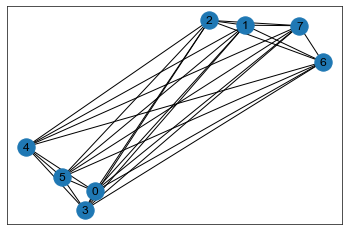

In [4]:
nx.draw_networkx(graph)

In [5]:
from recirq.qaoa.classical_angle_optimization import create_ZZ_HamC

In [6]:
import scipy.optimize
from recirq.qaoa.classical_angle_optimization import optimize_instance_interp_heuristic
from recirq.qaoa.problem_circuits import get_generic_qaoa_circuit

In [7]:
oresults = optimize_instance_interp_heuristic(graph=graph, p_max=1, flag_z2_sym=False, verbose=True)
oresults

-- p=1, F = -7.800 / -18.028399059529757, nfev=19, time=0.08 s


[OptimizationResult(p=1, f_val=-7.799710200920476, gammas=[0.16558082698560944], betas=[-0.4216025891304959], min_c=array(-18.02839906), max_c=array(18.08606026), pzstar=0.04421227161958218)]

In [8]:
sim = cirq.Simulator()
def calc_marginals(graph, gammas, betas):
    circuit = get_generic_qaoa_circuit(
        problem_graph=graph,
        qubits = cirq.LineQubit.range(graph.number_of_nodes()),
        gammas=gammas,
        betas=betas,
    )
    psi = sim.simulate(circuit)
    z_margs = []
    for i in range(graph.number_of_nodes()):
        z_marg = cirq.Z(cirq.LineQubit(i)).expectation_from_wavefunction(psi.final_state, psi.qubit_map)
        assert z_marg.imag < 1e-6, z_marg
        z_marg = z_marg.real
        z_margs += [z_marg]
    return z_margs

calc_marginals(graph, oresults[-1].gammas, oresults[-1].betas)

[0.1383485347032547,
 -0.41696012020111084,
 -0.07226941734552383,
 -0.16666720807552338,
 -0.3034420907497406,
 0.11819778382778168,
 0.2518828213214874,
 0.07749477028846741]

In [9]:
np.logspace(-2, 2, 12, base=2)

array([0.25      , 0.32166622, 0.41387664, 0.53252054, 0.68517549,
       0.88159125, 1.13431252, 1.45948011, 1.87786182, 2.41617889,
       3.10881256, 4.        ])

In [10]:
rs = np.random.RandomState(52)
records = []
scales = np.logspace(-2, 2, 12, base=2)
for graph_i in range(10):
#     papa_graph = nx.complete_graph(n_qubits)
#     papa_graph = random_plus_minus_1_weights(papa_graph, rs=rs)
    papa_graph = nx.random_regular_graph(3, n_qubits, seed=rs)
    nx.set_edge_attributes(papa_graph, values=1, name='weight')

    for scale in scales:
        graph = papa_graph.copy()
        
        if scale < 1:
            # scale down one-body terms
            obody = scale
        else:
            obody = 1
            # scale down two-body terms
            nx.set_edge_attributes(graph, values={(n1,n2): w/scale for n1, n2, w in papa_graph.edges.data('weight')}, name='weight')
        
        nx.set_node_attributes(
            graph, values={
                i: val
                for i, val in enumerate(rs.normal(scale=obody, size=graph.number_of_nodes()))},
                #for i, val in enumerate(rs.choice([obody, -obody], size=graph.number_of_nodes()))},
            name='weight')
        oresults = optimize_instance_interp_heuristic(graph=graph, p_max=2, flag_z2_sym=False, verbose=True)
        for oresult in oresults:
            marginals = calc_marginals(graph, oresult.gammas, oresult.betas)
            records += [{
                'graph_i': graph_i,
                'scale': scale,
                'marginals': np.asarray(marginals),
                'p': oresult.p,
            }]

-- p=1, F = -4.695 / -8.871386626799215, nfev=10, time=0.05 s
-- p=2, F = -6.529 / -8.871386626799215, nfev=16, time=0.02 s
-- p=1, F = -4.852 / -10.048972244622622, nfev=10, time=0.05 s
-- p=2, F = -6.836 / -10.048972244622622, nfev=16, time=0.01 s
-- p=1, F = -4.891 / -10.21622405513788, nfev=10, time=0.05 s
-- p=2, F = -6.778 / -10.21622405513788, nfev=15, time=0.02 s
-- p=1, F = -5.096 / -10.116449869615408, nfev=14, time=0.06 s
-- p=2, F = -6.775 / -10.116449869615408, nfev=15, time=0.01 s
-- p=1, F = -4.764 / -9.370940642311552, nfev=12, time=0.05 s
-- p=2, F = -6.582 / -9.370940642311552, nfev=16, time=0.01 s
-- p=1, F = -6.032 / -10.422631203980657, nfev=10, time=0.07 s
-- p=2, F = -7.815 / -10.422631203980657, nfev=13, time=0.01 s
-- p=1, F = -5.643 / -9.764167588667151, nfev=10, time=0.06 s
-- p=2, F = -7.032 / -9.764167588667151, nfev=14, time=0.01 s
-- p=1, F = -6.627 / -13.434005001854452, nfev=14, time=0.05 s
-- p=2, F = -9.431 / -13.434005001854452, nfev=15, time=0.01 s


-- p=2, F = -5.177 / -7.72305193006319, nfev=14, time=0.01 s
-- p=1, F = -6.791 / -10.882352976403252, nfev=9, time=0.06 s
-- p=2, F = -8.294 / -10.882352976403252, nfev=17, time=0.02 s
-- p=1, F = -3.291 / -5.823223791302383, nfev=9, time=0.05 s
-- p=2, F = -4.065 / -5.823223791302383, nfev=16, time=0.01 s
-- p=1, F = -4.560 / -6.380442222547908, nfev=8, time=0.08 s
-- p=2, F = -5.368 / -6.380442222547908, nfev=15, time=0.01 s
-- p=1, F = -3.596 / -8.43410219188895, nfev=10, time=0.05 s
-- p=2, F = -4.871 / -8.43410219188895, nfev=15, time=0.01 s
-- p=1, F = -3.627 / -9.159057737762582, nfev=10, time=0.06 s
-- p=2, F = -4.924 / -9.159057737762582, nfev=17, time=0.02 s
-- p=1, F = -3.895 / -10.08302662768495, nfev=11, time=0.06 s
-- p=2, F = -5.319 / -10.08302662768495, nfev=17, time=0.02 s
-- p=1, F = -3.616 / -8.660567456940287, nfev=10, time=0.07 s
-- p=2, F = -4.938 / -8.660567456940287, nfev=17, time=0.02 s
-- p=1, F = -3.959 / -9.881616362074936, nfev=11, time=0.06 s
-- p=2, F = 

In [10]:
import pandas as pd

In [11]:
# flat_records = []
# for record in records:
#     for m in record['marginals']:
#         flat_records.append({'scale': record['scale'], 'm': m})
# df = pd.DataFrame(flat_records)
# #sns.swarmplot(df['scale'], np.abs(df['m']))
# plt.scatter(df['scale'], np.abs(df['m']))

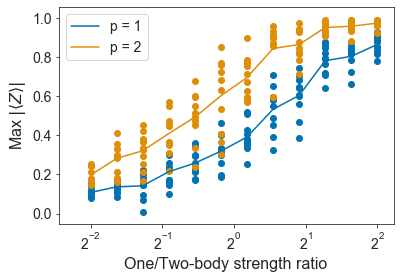

In [13]:
flat_records = []
for record in records:
    flat_records.append({
        'scale': record['scale'], 
        'maxm': max(np.abs(record['marginals'])),
        'p': record['p'],
    })
    
df = pd.DataFrame(flat_records)
#sns.swarmplot(df['scale'], np.abs(df['maxm']))
for p in [1, 2]:
    df0 = df.copy()
    df = df[df['p'] == p]
    plt.scatter(df['scale'], np.abs(df['maxm']))

    dfg = df.groupby('scale').agg('mean').reset_index()
    plt.plot(dfg['scale'], dfg['maxm'], label=f'p = {p}')
    
    df = df0

plt.xlabel('One/Two-body strength ratio')
plt.ylabel(r'Max $|\langle Z \rangle|$')
plt.legend(loc='best')
plt.xscale('log', basex=2)

In [12]:
def integrate_out(graph, i_remove, i_set, zstars):
    new_zstars = []
    for zstar in zstars:
        if 1-2*zstar[i_remove] != i_set:
            continue
        new_zstar = list(zstar)
        new_zstar.pop(i_remove)
        new_zstars.append(new_zstar)
    
    new_g = nx.Graph()
    offset = 0
    for i, w in graph.nodes.data('weight'):
        if w is None:
            w = 0
        if i == i_remove:
            offset += w*i_set
        else:
            new_g.add_node(i, weight=w)
    for i1, i2, w in graph.edges.data('weight'):
        if i1 == i_remove:
            new_g.nodes[i2]['weight'] += i_set * w
        elif i2 == i_remove:
            new_g.nodes[i1]['weight'] += i_set * w
        else:
            new_g.add_edge(i1, i2, weight=w)
            
    new_to_old = sorted(new_g.nodes)
    new_g = nx.relabel_nodes(new_g, {new_to_old[i]: i for i in range(new_g.number_of_nodes())})
    return new_g, offset, new_to_old, new_zstars

In [13]:
graph = nx.complete_graph(3)
graph = random_plus_minus_1_weights(graph, rs=np.random.RandomState(52))
nx.set_node_attributes(graph, values=0.5, name='weight')
graph.edges.data('weight')

EdgeDataView([(0, 1, 1), (0, 2, -1), (1, 2, 1)])

In [14]:
new_g, ofst, new_to_old, new_zstars = integrate_out(graph, 0, 1, [[0,1,0]])
new_g.edges.data('weight')

EdgeDataView([(0, 1, 1)])

In [15]:
new_zstars

[[1, 0]]

In [16]:
new_g.nodes.data('weight')

NodeDataView({0: 1.5, 1: -0.5}, data='weight')

In [17]:
ofst

0.5

In [18]:
new_to_old

[1, 2]

In [19]:
def print_graph_eqn(graph, offset):
    s = []
    for n1, n2, w in graph.edges.data('weight'):
        s += [f'{w:.2f}*Z{n1}Z{n2}']
    for n, w in graph.nodes.data('weight'):
        s += [f'{w:.2f}*Z{n}']
    s += [f'{offset:.2f}']
    return ' + '.join(s)

In [21]:
from recirq.qaoa.classical_angle_optimization import ising_qaoa_pzstar
from recirq.qaoa.simulation import ising_qaoa_expectation_and_variance
from recirq.qaoa.problems import asymmetric_coupling_ferromagnet_chain, partially_rounded_sk

In [22]:
partially_rounded_sk?

In [61]:
rs = np.random.RandomState(52)
records = []
n_qubits = 14
T = 0.02
#     papa_graph = nx.complete_graph(n_qubits)
#     papa_graph = random_plus_minus_1_weights(papa_graph, rs=rs)
papa_graph = nx.random_regular_graph(3, n_qubits, seed=rs)
nx.set_edge_attributes(papa_graph, values=1, name='weight')
# nx.set_node_attributes(
#     graph, values={
#         i: val
#         for i, val in enumerate(rs.normal(scale=0.1, size=graph.number_of_nodes()))},
#         #for i, val in enumerate(rs.choice([1, -1], size=graph.number_of_nodes()))},
#     name='weight')
# papa_graph = asymmetric_coupling_ferromagnet_chain(n_qubits, other_coupling=0.5, shuffle=False, rs=None)
# papa_graph = partially_rounded_sk(n=n_qubits, rs=rs, round_factor=0.0)

HamC = create_ZZ_HamC(papa_graph, flag_z2_sym=False,
                      node_to_index_map={i:i for i in range(papa_graph.number_of_nodes())}, dtype=np.complex128)
min_c = np.real_if_close(np.min(HamC))
print("!!", min_c, "!!")
answer_inds = np.where(HamC == np.min(HamC))[0]
print(answer_inds)
papa_zstars = np.asarray([cirq.big_endian_int_to_bits(answer_ind, bit_count=papa_graph.number_of_nodes())
                          for answer_ind in answer_inds])


records = []
for restart_i in range(20):
    graph = papa_graph.copy()
    zstars = [list(zstar) for zstar in papa_zstars]
    offset = 0
    while True:
        oresults = optimize_instance_interp_heuristic(graph=graph, p_max=2, flag_z2_sym=False, verbose=True)
        oresult = oresults[-1]
        print("sumfval", oresult.f_val + offset)
        print("    (offset)", offset)
        
        _, _, psi = ising_qaoa_expectation_and_variance(
            graph.number_of_nodes(), 
            create_ZZ_HamC(graph, flag_z2_sym=False, 
                           node_to_index_map={i:i for i in range(graph.number_of_nodes())}),
            np.concatenate((oresult.gammas, oresult.betas)),
            flag_z2_sym=False,
        )
        probs = np.abs(psi)**2
        pzstar = np.sum([probs[cirq.big_endian_bits_to_int(zstar)] for zstar in zstars])
#         pzstar = 0
#         print('zstars', zstars)
#         for zstar in zstars:
#             ind = cirq.big_endian_bits_to_int(zstar)
#             print(ind)
#             pzstar += probs[ind]
        print('pzstar', pzstar, oresult.pzstar)
        
        records += [{
            'restart_i': restart_i,
            'n': graph.number_of_nodes(),
            'f_val': oresult.f_val + offset,
            'pzstar': pzstar,
            'offset': offset,
        }]

        if graph.number_of_nodes() == 0:
            break
        marginals = calc_marginals(graph, oresult.gammas, oresult.betas)
        marginals = np.asarray(marginals)
        print('marginal', np.round(marginals, 3))
        prob_selec = np.exp(np.abs(marginals) / T)
        print('pselec. ', np.round(prob_selec, 3))
        prob_selec /= np.sum(prob_selec)
        fixi = rs.choice(len(marginals), p=prob_selec)
        print('fixing', fixi, marginals[fixi])
        graph, ofst, mapping, zstars = integrate_out(graph, fixi, 1 if marginals[fixi]>0 else -1, zstars)
        offset += ofst
        print(print_graph_eqn(graph, offset))


!! -17.0 !!
[ 2238  2746 13637 14145]
-- p=1, F = -7.759 / -17.0, nfev=11, time=0.67 s
-- p=2, F = -10.731 / -17.0, nfev=16, time=0.21 s
sumfval -10.730549295049173
    (offset) 0
pzstar 0.10241796054290338 0.10241796054290336
marginal [-0.  0.  0.  0.  0.  0.  0.  0. -0. -0.  0. -0. -0.  0.]
pselec.  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
fixing 9 -1.4901161193847656e-08
1.00*Z9Z10 + 1.00*Z9Z0 + 1.00*Z9Z7 + 1.00*Z10Z0 + 1.00*Z10Z4 + 1.00*Z8Z12 + 1.00*Z8Z1 + 1.00*Z8Z7 + 1.00*Z12Z11 + 1.00*Z5Z6 + 1.00*Z5Z2 + 1.00*Z5Z4 + 1.00*Z6Z3 + 1.00*Z6Z0 + 1.00*Z2Z1 + 1.00*Z2Z7 + 1.00*Z1Z11 + 1.00*Z11Z3 + 0.00*Z9 + 0.00*Z10 + 0.00*Z8 + -1.00*Z12 + 0.00*Z5 + 0.00*Z6 + 0.00*Z0 + 0.00*Z2 + 0.00*Z1 + -1.00*Z4 + 0.00*Z11 + 0.00*Z7 + -1.00*Z3 + 0.00
-- p=1, F = -7.414 / -17.0, nfev=12, time=0.38 s
-- p=2, F = -10.189 / -17.0, nfev=15, time=0.10 s
sumfval -10.188935762939616
    (offset) 0
pzstar 0.0776413774092602 0.07764137740926028
marginal [-0.    -0.     0.     0.513  0.513 -0.093 -0.093 -0.    -

-- p=1, F = -7.640 / -17.0, nfev=10, time=0.34 s
-- p=2, F = -10.423 / -17.0, nfev=15, time=0.10 s
sumfval -10.42282092155037
    (offset) 0
pzstar 0.08194980573069073 0.08194980573069072
marginal [ 0.441 -0.    -0.084 -0.    -0.089  0.    -0.089  0.471 -0.072  0.
  0.441  0.    -0.   ]
pselec.  [3.82385491e+09 1.00000000e+00 6.57270000e+01 1.00000000e+00
 8.51580000e+01 1.00000000e+00 8.51580000e+01 1.71156629e+10
 3.62270000e+01 1.00000000e+00 3.82387200e+09 1.00000000e+00
 1.00000000e+00]
fixing 7 0.47126519680023193
1.00*Z9Z0 + 1.00*Z9Z4 + 1.00*Z7Z11 + 1.00*Z7Z1 + 1.00*Z11Z10 + 1.00*Z11Z8 + 1.00*Z5Z6 + 1.00*Z5Z2 + 1.00*Z5Z4 + 1.00*Z6Z3 + 1.00*Z6Z0 + 1.00*Z2Z1 + 1.00*Z1Z10 + 1.00*Z4Z8 + 1.00*Z8Z3 + 1.00*Z10Z3 + -1.00*Z9 + 1.00*Z7 + 0.00*Z11 + 0.00*Z5 + 0.00*Z6 + -1.00*Z0 + 1.00*Z2 + 0.00*Z1 + 0.00*Z4 + 0.00*Z8 + 0.00*Z10 + 0.00*Z3 + -1.00
-- p=1, F = -7.151 / -16.0, nfev=13, time=0.21 s
-- p=2, F = -9.684 / -16.0, nfev=15, time=0.06 s
sumfval -10.684480820982948
    (offset) -1
pzst

-- p=1, F = -7.151 / -16.0, nfev=10, time=0.22 s
-- p=2, F = -9.836 / -16.0, nfev=15, time=0.06 s
sumfval -10.83620738754868
    (offset) -1
pzstar 0.0869811676302513 0.08698116763025127
marginal [ 0.45   0.     0.083  0.09  -0.52   0.    -0.083  0.    -0.483  0.45
  0.     0.077]
pselec.  [5.83478029e+09 1.00000000e+00 6.27620000e+01 9.01720000e+01
 1.91403060e+11 1.00000000e+00 6.27620000e+01 1.00000000e+00
 3.05200112e+10 5.83478899e+09 1.00000000e+00 4.72880000e+01]
fixing 4 -0.5195529460906982
1.00*Z8Z0 + 1.00*Z8Z5 + 1.00*Z6Z10 + 1.00*Z6Z1 + 1.00*Z6Z5 + 1.00*Z10Z9 + 1.00*Z10Z7 + 1.00*Z4Z3 + 1.00*Z4Z0 + 1.00*Z2Z1 + 1.00*Z2Z5 + 1.00*Z1Z9 + 1.00*Z7Z3 + 1.00*Z9Z3 + -1.00*Z8 + 0.00*Z6 + 0.00*Z10 + -1.00*Z4 + -1.00*Z0 + -1.00*Z2 + 0.00*Z1 + 1.00*Z7 + 0.00*Z9 + 0.00*Z5 + 0.00*Z3 + -2.00
-- p=1, F = -6.547 / -15.0, nfev=9, time=0.14 s
-- p=2, F = -8.924 / -15.0, nfev=16, time=0.04 s
sumfval -10.923748056892661
    (offset) -2
pzstar 0.05612474942960259 0.05612474942960262
marginal [ 0.345

-- p=1, F = -6.667 / -15.0, nfev=9, time=0.16 s
-- p=2, F = -9.056 / -15.0, nfev=15, time=0.04 s
sumfval -11.05647373557699
    (offset) -2
pzstar 0.05387154090352259 0.05387154090352259
marginal [ 0.454  0.     0.085  0.526 -0.526 -0.112 -0.085 -0.08   0.454 -0.178
  0.489]
pselec.  [7.28417707e+09 1.00000000e+00 7.08530000e+01 2.64893567e+11
 2.64895935e+11 2.63829000e+02 7.08530000e+01 5.32600000e+01
 7.28415536e+09 7.28181300e+03 4.15436929e+10]
fixing 4 -0.5260520577430725
1.00*Z7Z0 + 1.00*Z7Z5 + 1.00*Z6Z9 + 1.00*Z6Z1 + 1.00*Z6Z5 + 1.00*Z9Z8 + 1.00*Z4Z3 + 1.00*Z4Z0 + 1.00*Z2Z1 + 1.00*Z2Z5 + 1.00*Z1Z8 + 1.00*Z8Z3 + -1.00*Z7 + 0.00*Z6 + -1.00*Z9 + -1.00*Z4 + -1.00*Z0 + -1.00*Z2 + 0.00*Z1 + 0.00*Z8 + 0.00*Z5 + -1.00*Z3 + -3.00
-- p=1, F = -5.945 / -12.0, nfev=9, time=0.10 s
-- p=2, F = -6.379 / -12.0, nfev=16, time=0.04 s
sumfval -9.378664416019776
    (offset) -3
pzstar 0.0 0.026654282497990706
marginal [0.344 0.003 0.293 0.292 0.344 0.017 0.003 0.292 0.017 0.293]
pselec.  [2.991183

marginal [-0.346  0.074 -0.477 -0.444 -0.346  0.163  0.074 -0.444  0.163 -0.477]
pselec.  [3.23411620e+07 4.02300000e+01 2.25578409e+10 4.28297537e+09
 3.23412102e+07 3.45179500e+03 4.02300000e+01 4.28297537e+09
 3.45181300e+03 2.25578409e+10]
fixing 2 -0.4767869710922241
1.00*Z6Z0 + 1.00*Z6Z4 + 1.00*Z5Z8 + 1.00*Z5Z1 + 1.00*Z5Z4 + 1.00*Z8Z7 + 1.00*Z3Z2 + 1.00*Z3Z0 + 1.00*Z1Z7 + 1.00*Z7Z2 + 1.00*Z6 + 0.00*Z5 + 1.00*Z8 + 1.00*Z3 + 1.00*Z0 + -1.00*Z1 + 0.00*Z7 + -1.00*Z4 + 1.00*Z2 + -4.00
-- p=1, F = -5.596 / -11.0, nfev=8, time=0.07 s
-- p=2, F = -7.027 / -11.0, nfev=15, time=0.02 s
sumfval -11.027471054641309
    (offset) -4
pzstar 0.0 0.05149331044118578
marginal [-0.346  0.467 -0.438 -0.346  0.559 -0.083 -0.529  0.083 -0.467]
pselec.  [3.26723354e+07 1.38538671e+10 3.19090735e+09 3.26722380e+07
 1.35301851e+12 6.22750000e+01 3.11636422e+11 6.22750000e+01
 1.38538465e+10]
fixing 4 0.5586671829223633
1.00*Z5Z0 + 1.00*Z4Z7 + 1.00*Z4Z1 + 1.00*Z7Z6 + 1.00*Z3Z2 + 1.00*Z3Z0 + 1.00*Z1Z6 + 1.0

-- p=1, F = -4.416 / -8.0, nfev=9, time=0.06 s
-- p=2, F = -5.708 / -8.0, nfev=15, time=0.02 s
sumfval -10.708251527141648
    (offset) -5
pzstar 0.0 0.3341648110704517
marginal [-0.455  0.509 -0.159 -0.509  0.082  0.159 -0.082  0.455]
pselec.  [7.62295008e+09 1.12895222e+11 2.78460300e+03 1.12895222e+11
 6.14780000e+01 2.78460700e+03 6.14780000e+01 7.62299551e+09]
fixing 1 0.5089945197105408
1.00*Z4Z2 + 1.00*Z3Z6 + 1.00*Z3Z0 + 1.00*Z3Z2 + 1.00*Z6Z5 + 1.00*Z0Z5 + 0.00*Z4 + 0.00*Z3 + -1.00*Z6 + 1.00*Z1 + 1.00*Z0 + 1.00*Z5 + 1.00*Z2 + -6.00
-- p=1, F = -4.030 / -7.0, nfev=9, time=0.05 s
-- p=2, F = -5.375 / -7.0, nfev=15, time=0.01 s
sumfval -11.374627515425729
    (offset) -6
pzstar 0.0 0.4519861200642958
marginal [-0.419 -0.825 -0.546  0.099  0.179 -0.526  0.549]
pselec.  [1.24882078e+09 8.32833490e+17 7.18509127e+11 1.44429000e+02
 7.71169100e+03 2.58717463e+11 8.22077146e+11]
fixing 1 -0.8252722024917603
1.00*Z3Z1 + 1.00*Z2Z5 + 1.00*Z2Z0 + 1.00*Z2Z1 + 1.00*Z5Z4 + 1.00*Z0Z4 + 0.00*Z3 

marginal [ 0.14   0.478  0.6   -0.648  0.905 -0.279 -0.14 ]
pselec.  [1.07498000e+03 2.40034295e+10 1.08342239e+13 1.18220237e+14
 4.45242594e+19 1.15557275e+06 1.07498200e+03]
fixing 4 0.9048513174057007
1.00*Z4Z5 + 1.00*Z4Z0 + 1.00*Z5Z0 + 1.00*Z5Z1 + 1.00*Z2Z3 + 1.00*Z2Z1 + 1.00*Z3Z0 + 1.00*Z4 + 0.00*Z5 + -1.00*Z2 + 1.00*Z3 + 0.00*Z0 + -1.00*Z1 + -10.00
-- p=1, F = -3.463 / -7.0, nfev=9, time=0.05 s
-- p=2, F = -4.736 / -7.0, nfev=15, time=0.01 s
sumfval -14.735886196270478
    (offset) -10
pzstar 0.40915904712429557 0.40915904712429546
marginal [ 0.259  0.45   0.569 -0.594 -0.663 -0.027]
pselec.  [4.21243261e+05 6.04326989e+09 2.23027737e+12 7.84039521e+12
 2.46837258e+14 3.85700000e+00]
fixing 4 -0.6627950072288513
1.00*Z4Z0 + 1.00*Z4Z1 + 1.00*Z2Z3 + 1.00*Z2Z1 + 1.00*Z3Z0 + -1.00*Z4 + -1.00*Z2 + 1.00*Z3 + -1.00*Z0 + -1.00*Z1 + -11.00
-- p=1, F = -3.247 / -6.0, nfev=10, time=0.04 s
-- p=2, F = -4.179 / -6.0, nfev=15, time=0.01 s
sumfval -15.178975300745996
    (offset) -11
pzstar 0.

-- p=1, F = -3.933 / -8.0, nfev=8, time=0.05 s
-- p=2, F = -5.238 / -8.0, nfev=15, time=0.01 s
sumfval -14.23826043108042
    (offset) -9
pzstar 0.24745970379346138 0.24745970379346133
marginal [-0.583  0.938 -0.462  0.643 -0.249]
pselec.  [4.54431473e+12 2.27851665e+20 1.07834260e+10 9.28675541e+13
 2.55514398e+05]
fixing 1 0.9375045299530029
1.00*Z3Z2 + 1.00*Z3Z1 + 1.00*Z1Z0 + 1.00*Z2Z0 + 1.00*Z3 + 1.00*Z1 + -1.00*Z2 + 1.00*Z0 + -11.00
-- p=1, F = -2.710 / -6.0, nfev=8, time=0.03 s
-- p=2, F = -3.773 / -6.0, nfev=15, time=0.01 s
sumfval -14.773338644232666
    (offset) -11
pzstar 0.3143209606430664 0.3143209606430664
marginal [-0.592 -0.328  0.712 -0.592]
pselec.  [7.31467507e+12 1.34247798e+07 2.89477693e+15 7.31465328e+12]
fixing 2 0.7120336890220642
1.00*Z2Z1 + 1.00*Z1Z0 + 2.00*Z2 + 1.00*Z1 + 2.00*Z0 + -12.00
-- p=1, F = -2.923 / -5.0, nfev=10, time=0.03 s
-- p=2, F = -3.914 / -5.0, nfev=13, time=0.01 s
sumfval -15.913652553968621
    (offset) -12
pzstar 0.5245661774783912 0.52456

-- p=1, F = -2.103 / -5.0, nfev=10, time=0.04 s
-- p=2, F = -3.271 / -5.0, nfev=15, time=0.01 s
sumfval -15.27085701887255
    (offset) -12
pzstar 0.49124884990188145 0.4912488499018816
marginal [-0.768  0.319  0.768 -0.319]
pselec.  [4.85940539e+16 8.39868191e+06 4.85939090e+16 8.39871946e+06]
fixing 0 -0.7684455513954163
1.00*Z2Z1 + 0.00*Z2 + -1.00*Z0 + -2.00*Z1 + -13.00
-- p=1, F = -2.269 / -4.0, nfev=10, time=0.03 s
-- p=2, F = -3.443 / -4.0, nfev=15, time=0.01 s
sumfval -16.442545318215835
    (offset) -13
pzstar 0.7995594349540509 0.7995594349540509
marginal [ 0.965  0.869 -0.647]
pselec.  [9.04142218e+20 7.49132024e+18 1.11036957e+14]
fixing 0 0.965070366859436
1.00*Z1Z0 + 0.00*Z1 + -2.00*Z0 + -14.00
-- p=1, F = -1.695 / -3.0, nfev=9, time=0.03 s
-- p=2, F = -2.510 / -3.0, nfev=13, time=0.00 s
sumfval -16.509611363668505
    (offset) -14
pzstar 0.7999405759935526 0.7999405759935526
marginal [ 0.923 -0.614]
pselec.  [1.12978308e+20 2.11207968e+13]
fixing 0 0.9234745502471924
1.00

-- p=1, F = -7.759 / -17.0, nfev=11, time=0.95 s
-- p=2, F = -10.731 / -17.0, nfev=16, time=0.38 s
sumfval -10.730549295049173
    (offset) 0
pzstar 0.10241796054290338 0.10241796054290336
marginal [-0.  0.  0.  0.  0.  0.  0.  0. -0. -0.  0. -0. -0.  0.]
pselec.  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
fixing 5 7.450580596923828e-09
1.00*Z9Z10 + 1.00*Z9Z0 + 1.00*Z9Z6 + 1.00*Z10Z0 + 1.00*Z10Z4 + 1.00*Z7Z12 + 1.00*Z7Z1 + 1.00*Z7Z6 + 1.00*Z12Z11 + 1.00*Z12Z8 + 1.00*Z5Z3 + 1.00*Z5Z0 + 1.00*Z2Z1 + 1.00*Z2Z6 + 1.00*Z1Z11 + 1.00*Z4Z8 + 1.00*Z8Z3 + 1.00*Z11Z3 + 0.00*Z9 + 0.00*Z10 + 0.00*Z7 + 0.00*Z12 + 1.00*Z5 + 0.00*Z0 + 1.00*Z2 + 0.00*Z1 + 1.00*Z4 + 0.00*Z8 + 0.00*Z11 + 0.00*Z6 + 0.00*Z3 + 0.00
-- p=1, F = -7.414 / -17.0, nfev=10, time=0.61 s
-- p=2, F = -10.371 / -17.0, nfev=15, time=0.16 s
sumfval -10.371490203827703
    (offset) 0
pzstar 0.07836661918427969 0.07836661918427971
marginal [ 0.132  0.078 -0.483  0.083 -0.52  -0.52   0.091  0.     0.083  0.
  0.132 -0.     0.   ]
pselec. 

-- p=1, F = -7.414 / -17.0, nfev=10, time=0.60 s
-- p=2, F = -10.018 / -17.0, nfev=14, time=0.13 s
sumfval -10.018077629658173
    (offset) 0
pzstar 0.07173555334077399 0.071735553340774
marginal [-0.     0.505 -0.176 -0.     0.     0.    -0.     0.505 -0.083 -0.125
 -0.    -0.158  0.468]
pselec.  [1.00000000e+00 9.02423362e+10 6.72036900e+03 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.02428741e+10
 6.27740000e+01 5.08892000e+02 1.00000000e+00 2.74196800e+03
 1.47236058e+10]
fixing 7 0.5045154094696045
1.00*Z8Z9 + 1.00*Z8Z0 + 1.00*Z9Z0 + 1.00*Z9Z4 + 1.00*Z11Z10 + 1.00*Z11Z7 + 1.00*Z5Z6 + 1.00*Z5Z2 + 1.00*Z5Z4 + 1.00*Z6Z3 + 1.00*Z6Z0 + 1.00*Z2Z1 + 1.00*Z1Z10 + 1.00*Z4Z7 + 1.00*Z7Z3 + 1.00*Z10Z3 + 1.00*Z8 + 0.00*Z9 + -1.00*Z11 + 0.00*Z5 + 0.00*Z6 + 0.00*Z0 + 1.00*Z2 + -1.00*Z1 + 0.00*Z4 + 0.00*Z7 + 0.00*Z10 + 0.00*Z3 + -1.00
-- p=1, F = -7.034 / -16.0, nfev=10, time=0.30 s
-- p=2, F = -9.810 / -16.0, nfev=15, time=0.07 s
sumfval -10.80958710170727
    (offset) -1
pzsta

-- p=1, F = -7.034 / -16.0, nfev=10, time=0.25 s
-- p=2, F = -9.714 / -16.0, nfev=15, time=0.07 s
sumfval -10.714237364657741
    (offset) -1
pzstar 0.09855619638733194 0.09855619638733196
marginal [-0.     0.188 -0.     0.613  0.537 -0.104 -0.104  0.098 -0.498  0.
 -0.137 -0.613]
pselec.  [1.00000000e+00 1.18634320e+04 1.00000000e+00 2.02977660e+13
 4.54792336e+11 1.79614000e+02 1.79613000e+02 1.32609000e+02
 6.65774530e+10 1.00000000e+00 9.55364000e+02 2.02977660e+13]
fixing 11 -0.612830638885498
1.00*Z9Z10 + 1.00*Z9Z0 + 1.00*Z9Z7 + 1.00*Z10Z0 + 1.00*Z10Z4 + 1.00*Z8Z1 + 1.00*Z8Z7 + 1.00*Z5Z6 + 1.00*Z5Z2 + 1.00*Z5Z4 + 1.00*Z6Z3 + 1.00*Z6Z0 + 1.00*Z2Z1 + 1.00*Z2Z7 + 0.00*Z9 + 0.00*Z10 + 1.00*Z8 + 0.00*Z5 + 0.00*Z6 + 0.00*Z0 + 0.00*Z2 + -1.00*Z1 + -1.00*Z4 + 0.00*Z7 + -2.00*Z3 + -2.00
-- p=1, F = -7.028 / -15.0, nfev=11, time=0.14 s
-- p=2, F = -8.119 / -15.0, nfev=35, time=0.09 s
sumfval -10.118912146044815
    (offset) -2
pzstar 0.072678301434461 0.07267830143446102
marginal [-0.     

-- p=1, F = -7.028 / -15.0, nfev=9, time=0.15 s
-- p=2, F = -9.593 / -15.0, nfev=14, time=0.04 s
sumfval -11.592849302509624
    (offset) -2
pzstar 0.12784382956094553 0.1278438295609455
marginal [-0.    -0.641  0.332  0.113  0.113 -0.     0.641 -0.558 -0.139 -0.
 -0.897]
pselec.  [1.00000000e+00 8.44101527e+13 1.59669182e+07 2.77827000e+02
 2.77826000e+02 1.00000000e+00 8.44099012e+13 1.29691573e+12
 1.06443500e+03 1.00000000e+00 3.07884940e+19]
fixing 10 -0.8974734544754028
1.00*Z8Z9 + 1.00*Z8Z0 + 1.00*Z8Z6 + 1.00*Z9Z0 + 1.00*Z9Z3 + 1.00*Z4Z5 + 1.00*Z4Z1 + 1.00*Z4Z3 + 1.00*Z5Z2 + 1.00*Z5Z0 + 1.00*Z1Z6 + 1.00*Z3Z7 + 1.00*Z7Z2 + 0.00*Z8 + 0.00*Z9 + 0.00*Z4 + 0.00*Z5 + 0.00*Z0 + 1.00*Z1 + 0.00*Z3 + 1.00*Z7 + -1.00*Z6 + -1.00*Z2 + -4.00
-- p=1, F = -5.999 / -13.0, nfev=10, time=0.10 s
-- p=2, F = -8.275 / -13.0, nfev=14, time=0.02 s
sumfval -12.275295346618858
    (offset) -4
pzstar 0.15742002947960182 0.15742002947960182
marginal [ 0.    -0.634  0.634  0.112  0.112 -0.112  0.634 -0.634 

marginal [ 0.13   0.562 -0.094  0.53   0.    -0.53   0.094 -0.562  0.    -0.13 ]
pselec.  [6.72545000e+02 1.61497924e+12 1.07518000e+02 3.20280990e+11
 1.00000000e+00 3.20280036e+11 1.07518000e+02 1.61498405e+12
 1.00000000e+00 6.72545000e+02]
fixing 1 0.5622068643569946
1.00*Z7Z8 + 1.00*Z7Z0 + 1.00*Z7Z5 + 1.00*Z8Z0 + 1.00*Z8Z2 + 1.00*Z6Z5 + 1.00*Z3Z4 + 1.00*Z3Z1 + 1.00*Z3Z2 + 1.00*Z4Z0 + 1.00*Z1Z5 + 0.00*Z7 + 0.00*Z8 + 2.00*Z6 + 0.00*Z3 + 1.00*Z4 + 0.00*Z0 + 1.00*Z1 + -1.00*Z2 + 0.00*Z5 + -5.00
-- p=1, F = -5.763 / -12.0, nfev=10, time=0.08 s
-- p=2, F = -7.692 / -12.0, nfev=14, time=0.02 s
sumfval -12.692288104225891
    (offset) -5
pzstar 0.17219253258790598 0.17219253258790598
marginal [ 0.136 -0.554  0.554  0.123 -0.554  0.323 -0.894  0.    -0.136]
pselec.  [9.14214000e+02 1.05665672e+12 1.05666302e+12 4.66682000e+02
 1.05666302e+12 1.05283671e+07 2.62819339e+19 1.00000000e+00
 9.14217000e+02]
fixing 6 -0.8943082690238953
1.00*Z6Z7 + 1.00*Z6Z0 + 1.00*Z6Z5 + 1.00*Z7Z0 + 1.00*Z7Z2 +

-- p=1, F = -4.730 / -10.0, nfev=10, time=0.07 s
-- p=2, F = -6.350 / -10.0, nfev=15, time=0.02 s
sumfval -13.349970253816704
    (offset) -7
pzstar 0.2140765101698473 0.21407651016984725
marginal [ 0.137 -0.612  0.537  0.118 -0.537  0.612 -0.137 -0.137]
pselec.  [9.38604000e+02 1.96430835e+13 4.54456324e+11 3.61517000e+02
 4.54456324e+11 1.96431421e+13 9.38607000e+02 9.38605000e+02]
fixing 5 0.6121749877929688
1.00*Z5Z6 + 1.00*Z5Z0 + 1.00*Z6Z0 + 1.00*Z6Z2 + 1.00*Z3Z4 + 1.00*Z3Z1 + 1.00*Z3Z2 + 1.00*Z4Z0 + 1.00*Z5 + 0.00*Z6 + 0.00*Z3 + 1.00*Z4 + 0.00*Z0 + 2.00*Z1 + -1.00*Z2 + -8.00
-- p=1, F = -4.626 / -9.0, nfev=8, time=0.06 s
-- p=2, F = -6.177 / -9.0, nfev=15, time=0.01 s
sumfval -14.177108534874451
    (offset) -8
pzstar 0.2978670023368883 0.29786700233688834
marginal [ 0.263 -0.902  0.56   0.254 -0.56  -0.658 -0.015]
pselec.  [5.16891624e+05 3.78007914e+19 1.46622934e+12 3.21955841e+05
 1.46623808e+12 1.90222485e+14 2.12600000e+00]
fixing 1 -0.9015772342681885
1.00*Z4Z5 + 1.00*Z4Z0

-- p=2, F = -4.313 / -8.0, nfev=17, time=0.01 s
sumfval -13.31321352649011
    (offset) -9
pzstar 0.30947029348812327 0.30947029348812327
marginal [-0.402  0.418  0.052 -0.107  0.402 -0.402]
pselec.  [5.44848188e+08 1.17371641e+09 1.33550000e+01 2.09199000e+02
 5.33533518e+08 5.44848999e+08]
fixing 4 0.40190064907073975
1.00*Z3Z1 + 1.00*Z4Z2 + 1.00*Z1Z2 + 1.00*Z2Z0 + 0.00*Z3 + 2.00*Z4 + -1.00*Z1 + 0.00*Z2 + 2.00*Z0 + -10.00
-- p=1, F = -4.257 / -7.0, nfev=11, time=0.05 s
-- p=2, F = -4.471 / -7.0, nfev=37, time=0.02 s
sumfval -14.471428422351806
    (offset) -10
pzstar 0.40595146261214576 0.4059514626121459
marginal [-0.774  0.282  0.174 -0.161 -0.774]
pselec.  [6.32849851e+16 1.33969165e+06 5.95163900e+03 3.19327200e+03
 6.32849851e+16]
fixing 4 -0.7737284898757935
1.00*Z3Z1 + 1.00*Z1Z2 + 1.00*Z2Z0 + 0.00*Z3 + -1.00*Z1 + -1.00*Z2 + 2.00*Z0 + -12.00
-- p=1, F = -3.171 / -5.0, nfev=9, time=0.03 s
-- p=2, F = -3.175 / -5.0, nfev=27, time=0.01 s
sumfval -15.175266060899407
    (offset) -1

-- p=1, F = -1.695 / -3.0, nfev=9, time=0.03 s
-- p=2, F = -2.510 / -3.0, nfev=13, time=0.01 s
sumfval -16.509611363668505
    (offset) -14
pzstar 0.7999405759935337 0.7999405759935337
marginal [ 0.614 -0.923]
pselec.  [2.11205450e+13 1.12977298e+20]
fixing 1 -0.9234743714332581
-1.00*Z0 + -16.00
-- p=1, F = -1.000 / -1.0, nfev=6, time=0.02 s
-- p=2, F = -1.000 / -1.0, nfev=6, time=0.00 s
sumfval -17.0
    (offset) -16
pzstar 0.9999999999999996 0.9999999999999996
marginal [1.]
pselec.  [5.18470553e+21]
fixing 0 1.0
-17.00
-- p=1, F = 0.000 / 0.0, nfev=1, time=0.00 s
-- p=2, F = 0.000 / 0.0, nfev=1, time=0.00 s
sumfval -17.0
    (offset) -17
pzstar 1.0 1.0
-- p=1, F = -7.759 / -17.0, nfev=11, time=0.94 s
-- p=2, F = -10.731 / -17.0, nfev=16, time=0.34 s
sumfval -10.730549295049173
    (offset) 0
pzstar 0.10241796054290338 0.10241796054290336
marginal [-0.  0.  0.  0.  0.  0.  0.  0. -0. -0.  0. -0. -0.  0.]
pselec.  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
fixing 4 3.3527612686157227

-- p=1, F = -7.759 / -17.0, nfev=11, time=1.33 s
-- p=2, F = -10.731 / -17.0, nfev=16, time=0.27 s
sumfval -10.730549295049173
    (offset) 0
pzstar 0.10241796054290338 0.10241796054290336
marginal [-0.  0.  0.  0.  0.  0.  0.  0. -0. -0.  0. -0. -0.  0.]
pselec.  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
fixing 1 1.1920928955078125e-07
1.00*Z9Z10 + 1.00*Z9Z0 + 1.00*Z9Z6 + 1.00*Z10Z0 + 1.00*Z10Z3 + 1.00*Z7Z12 + 1.00*Z7Z6 + 1.00*Z12Z11 + 1.00*Z12Z8 + 1.00*Z4Z5 + 1.00*Z4Z1 + 1.00*Z4Z3 + 1.00*Z5Z2 + 1.00*Z5Z0 + 1.00*Z1Z6 + 1.00*Z3Z8 + 1.00*Z8Z2 + 1.00*Z11Z2 + 0.00*Z9 + 0.00*Z10 + 1.00*Z7 + 0.00*Z12 + 0.00*Z4 + 0.00*Z5 + 0.00*Z0 + 1.00*Z1 + 0.00*Z3 + 0.00*Z8 + 1.00*Z11 + 0.00*Z6 + 0.00*Z2 + 0.00
-- p=1, F = -7.414 / -17.0, nfev=10, time=0.48 s
-- p=2, F = -10.021 / -17.0, nfev=14, time=0.14 s
sumfval -10.020572089296278
    (offset) 0
pzstar 0.06854014755878449 0.06854014755878451
marginal [-0.    -0.505  0.083 -0.     0.088 -0.     0.176 -0.505 -0.    -0.
  0.    -0.468  0.158]
pselec. 

Text(0, 0.5, '$\\langle C \\rangle$')

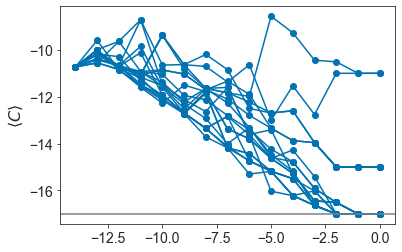

In [62]:
df = pd.DataFrame(records)
for restart_i in df['restart_i'].unique():
    df0 = df.copy()
    df = df[df['restart_i'] == restart_i]
    df = df.sort_values(by='n')
    plt.plot(-df['n'], df['f_val'], 'o-', color=sns.color_palette()[0])
    df = df0
plt.axhline(min_c, color='grey')
plt.ylabel(r'$\langle C \rangle$')

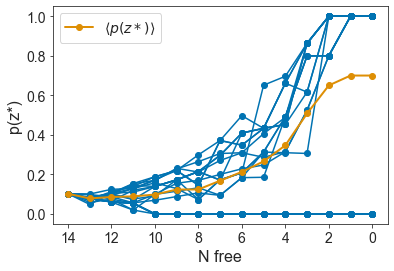

In [63]:
df = pd.DataFrame(records)
for restart_i in df['restart_i'].unique():
    df0 = df.copy()
    df = df[df['restart_i'] == restart_i]
    df = df.sort_values(by='n')
    plt.plot(-df['n'], df['pzstar'], 'o-', color=sns.color_palette()[0])
    df = df0
    
    
dfg = df.groupby('n').mean().reset_index()
plt.plot(-dfg['n'], dfg['pzstar'], 'o-', color=sns.color_palette()[1], 
         label=r'$\langle p(z*) \rangle$', zorder=10, lw=2)

plt.ylabel('p(z*)')
plt.xlabel('N free')
plt.xticks(list(range(-n_qubits, 0+1, 2)), [-n for n in range(-n_qubits, 0+1, 2)])
plt.legend(loc='best')

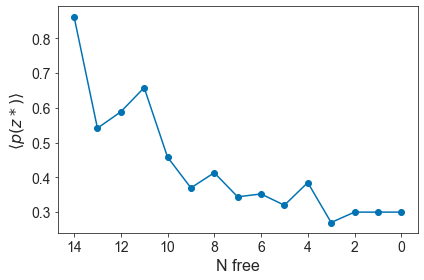

In [58]:
df = pd.DataFrame(records)
dfg = df.groupby('n').mean().reset_index()

plt.plot(-dfg['n'], dfg['pzstar'], 'o-')
plt.xlabel('N free')
plt.xticks(list(range(-n_qubits, 0+1, 2)), [-n for n in range(-n_qubits, 0+1, 2)])
plt.ylabel(r'$\langle p(z*) \rangle$')

plt.tight_layout()

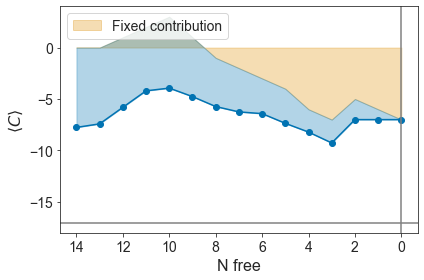

In [37]:
df = pd.DataFrame(records)
plt.plot(-df['n'], df['f_val'], 'o-', color=sns.color_palette()[0])
plt.fill_between(-df['n'], df['offset'], color=sns.color_palette()[1], alpha=0.3, label='Fixed contribution')
plt.fill_between(-df['n'], df['f_val'], df['offset'], color=sns.color_palette()[0], alpha=0.3)
plt.axvline(0, color='grey')
plt.axhline(min_c, color='grey')
plt.legend(loc='best')
plt.ylabel(r'$\langle C \rangle$')
plt.xlabel('N free')
plt.xticks(list(range(-n_qubits, 0+1, 2)), [-n for n in range(-n_qubits, 0+1, 2)])
plt.tight_layout()


In [87]:
sim = cirq.Simulator()

def expectation(graph, gammas, betas):
    ret = 0
    psi = sim.simulate(get_generic_qaoa_circuit(
            problem_graph=graph,
            qubits = cirq.LineQubit.range(graph.number_of_nodes()),
            gammas=gammas,
            betas=betas,
    ))
    for i1, i2, w in graph.edges.data('weight'):
        zz_val = w * (cirq.Z(cirq.LineQubit(i1)) * cirq.Z(cirq.LineQubit(i2)))\
                             .expectation_from_wavefunction(psi.final_state, psi.qubit_map)
        assert zz_val.imag < 1e-6, zz_val
        zz_val = zz_val.real
        ret += zz_val
    for i1, w in graph.nodes.data('weight'):
        z_val = w * (cirq.Z(cirq.LineQubit(i1))) \
                             .expectation_from_wavefunction(psi.final_state, psi.qubit_map)
        assert z_val.imag < 1e-6, z_val
        z_val = z_val.real
        ret += z_val
    return ret

In [88]:
expectation(graph, oresults[-1].gammas, oresults[-1].betas), oresults[-1].f_val

(0, 0.0)